# Process AZFP echosounder data using externally stored glider data

## Introduction

### Goals

- Update platform location data in an echosounder converted dataset using data from an external file.
- Use environmental data from an external file to calibrate the backscatter data.
- Demonstrate the processing of ASL Environmental Sciences AZFP echosounder files.

### Description

When an echosounder raw data file does not contain location (latitude and longitude) and environmental (temperature, salinity and pressure) data, `echopype` can be used to integrate such data from external sources. This notebook illustrates these steps using data provided by personnel from the [Department of Marine and Coastal Sciences at Rutgers University](https://marine.rutgers.edu/). The data was collected by a Slocum glider deployed in the Southern Ocean off Antarctica (Ross Sea) in 2018 and fitted with an [Acoustic Zooplankton and Fisher Profiler (AZFP)](https://aslenv.com/azfp.html) echosounder from ASL Environmental Sciences. The data used here are from a single dive and span approximately 15 minutes. We thank [Delphine Mossman](https://rucool.marine.rutgers.edu/people/delphine-mossman/) for providing these data files and background information.

In this notebook we don't attempt to correct for the orientation of the glider or apply any other processing steps that would be required to correctly interpret the echosounder data. Such steps are discussed in the [2021 M.S. thesis from Ailey Sheehan](https://rucool.marine.rutgers.edu/wp-content/uploads/2022/06/Ailey_Thesis_FinalDraft.pdf), another member of the same Rutgers team. The computations are available in the associated GitHub repository, https://github.com/a-sheehan/Echopype-Processing-Pipeline-for-AZFP-and-Glider-Data

### Running the notebook

This notebook can be run with a [conda](https://docs.conda.io) environment created using the [instructions in the accompanying GitHub repository README.md file.](https://github.com/OSOceanAcoustics/echopype-examples#run-the-notebooks-locally-on-your-machine). It uses data files found in the `notebooks/data` directory in this repository (https://github.com/OSOceanAcoustics/echopype-examples/).

In [1]:
from pathlib import Path

import geopandas as gpd
import pandas as pd
import xarray as xr
from scipy.spatial.transform import Rotation as R
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import echopype as ep
import echopype.colormap

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Set path to example data:

In [2]:
data_dpath = Path('./example_data/Glider_AZFP')

## Open data files and convert the raw AZFP data

### Open and convert raw AZFP data

To open an AZFP data file (`*.01A` files), the accompanying `XML` metadata file must be provided.

In [3]:
azfp_data_fpath = data_dpath / "18011107.01A"

ed = ep.open_raw(
    azfp_data_fpath, 
    xml_path=data_dpath / "18011107.XML", 
    sonar_model="AZFP"
)

Add global and platform attributes to `EchoData` object

In [4]:
ed

<EchoData: standardized raw data from Internal Memory>
Top-level: contains metadata about the SONAR-netCDF4 file format.
├── Environment: contains information relevant to acoustic propagation through water.
├── Platform: contains information about the platform on which the sonar is installed.
├── Provenance: contains metadata about how the SONAR-netCDF4 version of the data were obtained.
├── Sonar: contains sonar system metadata and sonar beam groups.
│   └── Beam_group1: contains backscatter power (uncalibrated) and other beam or channel-specific data.
└── Vendor_specific: contains vendor-specific information about the sonar and the data.

AZFP raw data files don't store latitude and longitude data. Therefore, the `Platform` group does not contain such data (or the variables).

In [5]:
"latitude" in ed["Platform"].data_vars, "longitude" in ed["Platform"].data_vars

(True, True)

As this echosounder is deployed on a glider that collects independent CTD data, the temperature sensor is disabled. The `temperature` variable is filled with `nan`.

In [6]:
ed["Environment"]

<xarray.Dataset> Size: 188B
Dimensions:                 (channel: 3)
Coordinates:
  * channel                 (channel) <U11 132B '59006-38-1' ... '59006-200-3'
Data variables:
    absorption_indicative   (channel) float64 24B nan nan nan
    sound_speed_indicative  float64 8B nan
    frequency_nominal       (channel) float64 24B 3.8e+04 1.25e+05 2e+05

### Open external glider data netCDF file

The glider data are available at http://slocum-data.marine.rutgers.edu/erddap/tabledap/ru32-20180109T0531-profile-sci-delayed.html. We previously downloaded, subset and pre-processed that dataset to make it easier to use in this example.

In [7]:
glider_nc_fpath = data_dpath / "ru32-20180109T0531-profile-sci-delayed-subset.nc"

In [8]:
glider_ds = xr.open_dataset(glider_nc_fpath)
glider_ds

<xarray.Dataset> Size: 454kB
Dimensions:                    (time: 915)
Coordinates:
  * time                       (time) datetime64[ns] 7kB 2018-01-11T07:26:20....
Data variables: (12/59)
    latitude                   (time) float64 7kB ...
    longitude                  (time) float64 7kB ...
    depth                      (time) float32 4kB ...
    trajectory                 (time) <U18 66kB ...
    source_file                (time) <U31 113kB ...
    beta_700nm                 (time) float32 4kB ...
    ...                         ...
    sci_water_pressure         (time) float32 4kB ...
    sound_speed                (time) float32 4kB ...
    temperature                (time) float32 4kB ...
    u                          (time) float32 4kB ...
    v                          (time) float32 4kB ...
    water_depth                (time) float32 4kB ...
Attributes: (12/72)
    cdm_data_type:                   Profile
    cdm_profile_variables:           profile_id
    comment:                         Glider was deployed/recovered from the R...
    contributor_name:                Grace Saba, Dave Aragon, Chip Haldeman, ...
    contributor_role:                Principal Investigator, Glider Pilot, Gl...
    Conventions:                     CF-1.6, COARDS, ACDD-1.3
    ...                              ...
    time_coverage_resolution:        PTS
    time_coverage_start:             2018-01-09T05:29:54Z
    title:                           ru32-20180109T0531 Delayed Science Profile
    uuid:                            82c40f91-87ab-40bb-a1ea-3f1c366a0378
    Westernmost_Easting:             164.36469500000004
    wmo_id:                          7801506

The external glider data time range encompasses that of the AZFP data. Let's compare the two time ranges:

In [9]:
glider_ds.time.min().values, glider_ds.time.max().values

(np.datetime64('2018-01-11T07:26:20.320559872'),
 np.datetime64('2018-01-11T08:00:28.788059904'))

In [10]:
ed["Sonar/Beam_group1"]["ping_time"].min().values, ed["Sonar/Beam_group1"]["ping_time"].max().values

(np.datetime64('2018-01-11T07:44:40.000000000'),
 np.datetime64('2018-01-11T07:59:59.000000000'))

## Update EchoData `Platform` group with glider data and metadata

### Update Platform and Top-level metadata

While not required for data processing, it's always a good idea to include as much metadata as possible. We'll take advantage of the metadata found in the glider netCDF file to populate some of this metadata.

In [11]:
# Manually populate additional metadata about the dataset and the platform
# -- SONAR-netCDF4 Top-level Group attributes
ed['Top-level'].attrs['title'] = "2018 Ross Sea Slocum glider AZFP echosounder data from Rutgers University"
ed['Top-level'].attrs['summary'] = glider_ds.attrs['summary']

# -- SONAR-netCDF4 Platform Group attributes
ed['Platform'].attrs['platform_type'] = glider_ds.attrs['platform_type']
ed['Platform'].attrs['platform_name'] = "Rutgers r32 Slocum Webb G2 glider"
ed['Platform'].attrs['platform_code_ICES'] = glider_ds.attrs['wmo_id']

Here are the updated attributes in the "Top-level" group:

In [12]:
ed['Top-level'].attrs

{'conventions': 'CF-1.7, SONAR-netCDF4-1.0, ACDD-1.3',
 'keywords': 'AZFP',
 'sonar_convention_authority': 'ICES',
 'sonar_convention_name': 'SONAR-netCDF4',
 'sonar_convention_version': '1.0',
 'summary': 'This project integrated an Acoustic Zooplankton and Fish Profiler (AZFP) multi-frequency echo sounder into a Slocum Webb G2 glider. The AZFP is complemented with existing glider sensors including a CTD, a WET Labs BB2FL ECO puck configured for simultaneous chlorophyll fluorescence (phytoplankton biomass) and optical backscatter measurements, and an Aanderaa Optode for measuring dissolved oxygen. This glider deployment is located in the polynya of Terra Nova Bay (western Ross Sea, Antarctica), and is focused on investigating relationships between phytoplankton-zooplankton-fish distributions and the physical drivers of zooplankton and silverfish species and size distributions.',
 'title': '2018 Ross Sea Slocum glider AZFP echosounder data from Rutgers University',
 'date_created': '20

### Update latitude and longitude data

The external glider file name, `glider_nc_fpath.name`, is used in `update_platform` only to store it as provenance information recording the origin of the data.

In [13]:
ed.update_platform(
        glider_ds,
        variable_mappings={"latitude": "latitude", "longitude": "longitude"},
        extra_platform_data_file_name=glider_nc_fpath.name,
)

`latitude` and `longitude` variables are now found in the `Platform` group. Note also the global platform attributes added in the previous step.

In [14]:
ed['Platform']

<xarray.Dataset> Size: 21kB
Dimensions:              (time3: 872, time2: 1, channel: 3)
Coordinates:
  * channel              (channel) <U11 132B '59006-38-1' ... '59006-200-3'
  * time2                (time2) datetime64[ns] 8B 2018-01-11T07:44:40
  * time3                (time3) datetime64[ns] 7kB 2018-01-11T07:26:30.39312...
Data variables: (12/21)
    latitude             (time3) float64 7kB -75.02 -75.02 ... -75.02 -75.02
    longitude            (time3) float64 7kB 165.5 165.5 165.5 ... 165.5 165.5
    pitch                (time2) float64 8B nan
    roll                 (time2) float64 8B nan
    vertical_offset      (time2) float64 8B nan
    water_level          float64 8B nan
    ...                   ...
    MRU_rotation_y       float64 8B nan
    MRU_rotation_z       float64 8B nan
    position_offset_x    float64 8B nan
    position_offset_y    float64 8B nan
    position_offset_z    float64 8B nan
    frequency_nominal    (channel) float64 24B 3.8e+04 1.25e+05 2e+05
Attributes:
    platform_name:       Rutgers r32 Slocum Webb G2 glider
    platform_type:       Slocum Glider
    platform_code_ICES:  7801506

The source of the location data is preserved as provenance "history" attributes in the `latitude` and `longitude` variables:

In [15]:
ed['Platform']['latitude'].history

'2024-07-26 22:01:16.118686 +00:00. Added from external platform data, from file ru32-20180109T0531-profile-sci-delayed-subset.nc. From external latitude variable.'

### Plot glider location

Extract and join together the `latitude` and `longitude` variables from the `Platform` group in the `ed` EchoData object. Convert to a `Pandas` DataFrame first, then to a `GeoPandas` GeoDataFrame for convenient viewing and manipulation.

In [16]:
gps_df = ed['Platform'].latitude.to_dataframe().join(ed['Platform'].longitude.to_dataframe())
gps_df.head(3)

,latitude,longitude
time3,,
2018-01-11 07:26:30.393129984,-75.018896,165.499855
2018-01-11 07:48:05.826169856,-75.017433,165.500057
2018-01-11 07:48:06.832060160,-75.017432,165.500058


This is the geographic bounding box

In [17]:
gps_gdf = gpd.GeoDataFrame(
    gps_df,
    geometry=gpd.points_from_xy(gps_df['longitude'], gps_df['latitude']), 
    crs="epsg:4326"
)

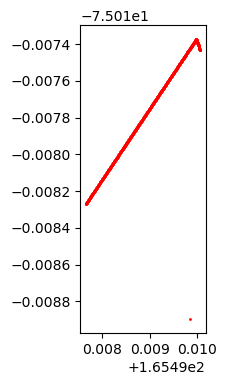

In [18]:
gps_gdf.plot(markersize=1, color='red', figsize=(2,4));

In [19]:
(gps_df.longitude.min(), gps_df.longitude.max()), (gps_df.latitude.min(), gps_df.latitude.max())

((165.49765868921702, 165.50005833333333),
 (-75.01889590423247, -75.01737333333334))

Plot with `matplotlib` and `cartopy` using a South Polar Stereo map projection.

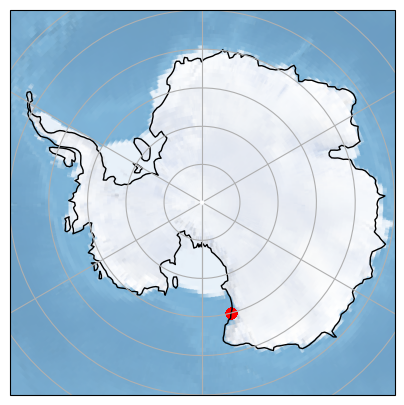

In [20]:
_, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": ccrs.SouthPolarStereo()})
ax.set_extent([-180, 180, -90, -65], crs=ccrs.PlateCarree())
ax.coastlines(resolution='110m')
ax.stock_img()
ax.gridlines()
gps_gdf.plot(ax=ax, markersize=50, color='red', transform=ccrs.PlateCarree(), aspect=None);

## Calibrate with glider mean environmental data

We'll use the environmental data (temperature, salinity and pressure) found in the external glider file to calibrate the backscatter data and create a volume backscattering strength (`Sv`) dataset.

In [21]:
env_params_means = {}
for env_var in ["temperature", "salinity", "pressure"]:
    env_params_means[env_var] = float(glider_ds[env_var].mean().values)

In [22]:
env_params_means

{'temperature': -1.020638108253479,
 'salinity': 34.53363037109375,
 'pressure': 38.693416595458984}

In [23]:
ds_Sv = ep.calibrate.compute_Sv(ed, env_params=env_params_means)
ds_Sv

<xarray.Dataset> Size: 88MB
Dimensions:                (channel: 3, ping_time: 920, range_sample: 1999,
                            filenames: 1)
Coordinates:
  * channel                (channel) <U11 132B '59006-38-1' ... '59006-200-3'
  * ping_time              (ping_time) datetime64[ns] 7kB 2018-01-11T07:44:40...
  * range_sample           (range_sample) int64 16kB 0 1 2 3 ... 1996 1997 1998
  * filenames              (filenames) int64 8B 0
Data variables: (12/18)
    Sv                     (channel, ping_time, range_sample) float64 44MB -1...
    echo_range             (channel, ping_time, range_sample) float64 44MB 0....
    frequency_nominal      (channel) float64 24B 3.8e+04 1.25e+05 2e+05
    sound_speed            float64 8B 1.444e+03
    sound_absorption       (channel) float64 24B 0.009111 0.03012 0.04501
    temperature            float64 8B -1.021
    ...                     ...
    TVR                    (channel) float64 24B 156.2 168.5 165.9
    VTX0                   (channel) float64 24B 157.0 146.7 133.3
    equivalent_beam_angle  (channel) float64 24B 0.1306 0.01071 0.01071
    Sv_offset              (channel) float64 24B 0.7 0.3 0.3
    source_filenames       (filenames) <U37 148B 'example_data/Glider_AZFP/18...
    water_level            float64 8B nan
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.8.2.dev203+g11f15de
    processing_time:              2024-07-26T22:01:17Z
    processing_function:          calibrate.compute_Sv

### Add latitude, longitude Sv

In [24]:
ds_Sv = ep.consolidate.add_location(ds_Sv, ed)

### Add Depth

In [25]:
# Grab pitch and roll from platform group
pitch = np.rad2deg(glider_ds["m_pitch"])
roll = np.rad2deg(glider_ds["m_roll"])

# Compute tilt in degrees from pitch roll rotations
yaw = np.zeros_like(pitch.values)
yaw_pitch_roll_euler_angles_stack = np.column_stack([yaw, pitch.values, roll.values])
yaw_rot_pitch_roll = R.from_euler("ZYX", yaw_pitch_roll_euler_angles_stack, degrees=True)
glider_tilt = yaw_rot_pitch_roll.as_matrix()[:, -1, -1]
glider_tilt = xr.DataArray(
    glider_tilt, dims="time", coords={"time": glider_ds["time"]}
)
glider_tilt = np.rad2deg(glider_tilt)

In [26]:
# Add depth to Sv dataset incorporating Glider depth and tilt data
ds_Sv = ep.consolidate.add_depth(
    ds_Sv,
    depth_offset=glider_ds["depth"].dropna("time"),
    tilt=glider_tilt.dropna("time"),
)

## Plot Echograms

TODO: This is currently wrong. I think I messed up the tilt calculation somehow.

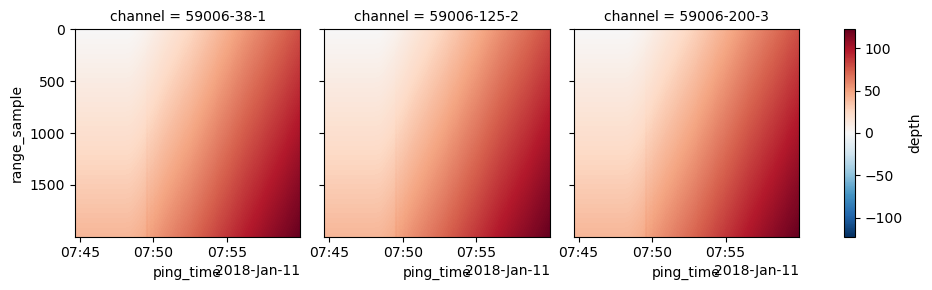

In [28]:
ds_Sv["depth"].plot(col="channel", yincrease=False, y="range_sample")

## Package versions

In [27]:
import datetime
print(f"echopype: {ep.__version__}, xarray: {xr.__version__}, geopandas: {gpd.__version__}")

print(f"\n{datetime.datetime.utcnow()} +00:00")

echopype: 0.8.2.dev203+g11f15de, xarray: 2024.6.0, geopandas: 1.0.1

2024-07-26 22:01:18.032201 +00:00
